In [1]:
#This code imports the Johns Hopkins daily reports from their GitHub repository
#It takes the daily files and creates a single file for analysis
#The columns differ so we will convert all data to use the following columns
#columns=['Date', 'Region', 'Province', 'Country', 'Total_Confirmed', 'Total_Deaths', 'Total_Recovered']
#The structure changes over time, so we will have to modify the data for each date range to make it consistent
import pandas as pd
import numpy as np
import math
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
import requests
import urllib
from bs4 import BeautifulSoup
import csv
import os.path

# Gaussian model to generate the fitted curve
def gaussian_fit(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)

# This function implements the derivative calculations
def SICRDS_derivatives(y, t, N, beta, gamma, delta, sigma):
    S, I, C, R, D = y
    dS = -beta * S * C / N
    dI = (beta * S * C / N) - sigma * I
    dC = (sigma * I) - ((gamma + delta) * C)
    dR = gamma * C
    dD = delta * C
    return dS, dI, dC, dR, dD

In [2]:
# STEP 1: We want to download all the files to local disk just so we have the records

#We need create a list of string dates from 01/22 through today
start_date = date(2020,1,22)
end_date = date.today()
period = end_date - start_date
datelist = []

for dindex in range(period.days):
    currentdate = start_date + timedelta(days=dindex)
    datelist.append(currentdate.strftime('%m-%d-%Y'))

#Note: This code will overwrite any files that were downloaded earlier
for d in datelist:
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + d + '.csv'
    fn = 'DATA/JHU/DAILY/' + d + '-JHU-DAILY.csv'
    if not (os.path.exists(fn)):
        urllib.request.urlretrieve(url, fn)
        
# STEP 2: Load data for 01/22 through 03/21

#Setup the date range for the first period
start_date = date(2020,1,22)
end_date = date(2020,3,22)
period = end_date - start_date

#Create an empty list to hold the range of date strings
drng1 = []

#Loop through the dae range and populate the list of date strings
for dindex in range(period.days):
    currentdate = start_date + timedelta(days=dindex)
    drng1.append(currentdate.strftime('%m-%d-%Y'))

#Create an empty dataframe with the standard columns
df1 = pd.DataFrame(columns=['Date', 'Region', 'Province', 'Country', 'Total_Confirmed', 'Total_Deaths', 'Total_Recovered', 'Total_Active'])

#Loop through the date range and put all the date into one file
for d in drng1:
    #Load the data file for this particular date in the loop
    fn = 'DATA/JHU/DAILY/' + d + '-JHU-DAILY.csv'
    rdf = pd.read_csv(fn)
    
    #Rename and remove columns
    rdf = rdf.rename(columns={"Province/State":"Province", "Country/Region":"Country", "Confirmed":"Total_Confirmed", "Deaths":"Total_Deaths", "Recovered":"Total_Recovered", "Active":"Total_Active"})
    rdf = rdf.drop(['Last Update'],axis=1)
    
    #JHU added Latitude and Longitude columns starting 03/01 so we just check if they exist and drop them
    if "Latitude" in rdf.columns:
        rdf = rdf.drop(['Latitude','Longitude'],axis=1)
    
    #Set the date corresponding to the date of the file (i.e. filename)
    rdf["Date"] = d
    
    #Region did not exist in this date range, so set it to NaN
    rdf["Region"] = np.nan
    
    #Append the data to the master data file for this range
    df1 = df1.append(rdf)

#STEP 3: Load data from 03/22 through today

#Setup the date range for the first period
start_date = date(2020,3,22)
end_date = date.today()
period = end_date - start_date

#Create an empty list to hold the range of date strings
drng2 = []

#Loop through the dae range and populate the list of date strings
for dindex in range(period.days):
    currentdate = start_date + timedelta(days=dindex)
    drng2.append(currentdate.strftime('%m-%d-%Y'))

#Create an empty dataframe with the standard columns
df2 = pd.DataFrame(columns=['Date', 'Region', 'Province', 'Country', 'Total_Confirmed', 'Total_Deaths', 'Total_Recovered', 'Total_Active'])
    
#Loop through the date range and put all the date into one file
for d in drng2:
    #Load the data file for this particular date in the loop
    fn = 'DATA/JHU/DAILY/' + d + '-JHU-DAILY.csv'
    rdf = pd.read_csv(fn)
    
    #Rename and remove columns
    rdf = rdf.rename(columns={"Admin2":"Region", "Province_State":"Province", "Country_Region":"Country", "Confirmed":"Total_Confirmed", "Deaths":"Total_Deaths", "Recovered":"Total_Recovered", "Active":"Total_Active"})
    rdf = rdf.drop(['FIPS','Last_Update','Lat','Long_','Combined_Key'],axis=1)
    
    #Set the date corresponding to the date of the file (i.e. filename)
    rdf["Date"] = d
    
    #Append the data to the master data file for this range
    df2 = df2.append(rdf)
    
#STEP 4: Combine the data into one final file and write to disk
df = df1
df = df.append(df2)
dstr = date.today().strftime('%Y-%m-%d')
df.to_csv('DATA/JHU/' + dstr + '-COVID-19-JHU-DAILY.csv',index=False)
df.to_csv('DATA/JHU/covid-19-jhu-worldwide-daily.csv',index=False)

#STEP 6: Wrangle the data to get a clean file with data by date and state within the US

tempdf = df.copy()

start_date = date(2020,3,22)
end_date = date.today()
period = end_date - start_date

#Convert to datetime so it sorts by date, not by string
tempdf.Date = pd.to_datetime(tempdf.Date)

#Filter out all countries except the US
tempdf = tempdf.reset_index(drop=True)
tempdf = tempdf.sort_values(by=['Date'])
tempdf = tempdf[tempdf.Country == 'US']

#Drop all records that contain data for individual cities in the Province field (they contain a comma)
tempdf = tempdf.reset_index(drop=True)
tempdf = tempdf.sort_values(by=['Date'])
tempdf = tempdf.drop(tempdf[tempdf.Province.str.contains(',')].index)

#Remove the extraneous province data
tempdf = tempdf.reset_index(drop=True)
tempdf = tempdf.sort_values(by=['Date'])
remove_list = ['Chicago','Unassigned Location (From Diamond Princess)','Grand Princess Cruise Ship','Grand Princess','Diamond Princess','Wuhan Evacuee','Recovered','Northern Mariana Islands','American Samoa','Guam','United States Virgin Islands','Virgin Islands','US']
tempdf = tempdf[~tempdf.Province.isin(remove_list)]
tempdf = tempdf.reset_index(drop=True)
tempdf = tempdf.sort_values(by=['Date'])

#Get a list of unique provinces (i.e. States) from the filtered list
provinces = pd.DataFrame(tempdf.Province.unique())
provinces = provinces.rename(columns={0:"Province"})

#STEP 6A: Get the data up through 03/21, which does not have any Province data

#Make a copy of the data for the first grouping of dates
dfgrp1 = tempdf.copy()

#Remove data after 03/21 that has the data broken down by Region/County
dfgrp1 = dfgrp1[dfgrp1.Date < pd.to_datetime(start_date)]

#STEP 6B: Next we need to sum up the data for each Province/State by date for data after 03/21

#Start by getting filtering the data to only the records after 03/21
dfr = tempdf[tempdf.Date >= pd.to_datetime(start_date)]

#Create an empty dataframe with the standard columns
dfgrp2 = pd.DataFrame(columns=['Date', 'Region', 'Province', 'Country', 'Total_Confirmed', 'Total_Deaths','Total_Recovered','Total_Active'])
#dfgrp2 = pd.DataFrame(columns=['Date'])

#Loop through the date range and create the records grouped by state from 03/22 through the end_date (yesterday)
for dindex in range(period.days):
    #Get the day for this iteration in the loop
    day = start_date + timedelta(days=dindex)
    
    #Loop through all the provinces and create daily records with the sum of the data columns
    for index, p in provinces.iterrows():
        tc = dfr[(dfr.Date == pd.to_datetime(day)) & (dfr.Province == p.Province)].Total_Confirmed.sum()
        td = dfr[(dfr.Date == pd.to_datetime(day)) & (dfr.Province == p.Province)].Total_Deaths.sum()
        tr = dfr[(dfr.Date == pd.to_datetime(day)) & (dfr.Province == p.Province)].Total_Recovered.sum()
        ta = dfr[(dfr.Date == pd.to_datetime(day)) & (dfr.Province == p.Province)].Total_Active.sum()
        newrow = {'Date': day, 'Region':np.nan, 'Province':p.Province, 'Country':'US','Total_Confirmed':tc,'Total_Deaths':td,'Total_Recovered':tr,'Total_Active':ta}
        dfgrp2 = dfgrp2.append(newrow,ignore_index=True)

#Combine the two groups to make one dataframe that contains the data for all dates
dfstates = dfgrp1.append(dfgrp2)

#Write the data to a file for inspection and backup
dfstates.Date = pd.to_datetime(dfstates.Date)
dstr = date.today().strftime('%Y-%m-%d')
dfstates.to_csv('DATA/JHU/' + dstr + '-COVID-19-JHU-BYSTATE.csv',index=False)

#STEP 7: Add the data for the missing days for each Province (State) and merge in population data

df7 = dfstates.copy()

start_date = dfstates.Date.min()
end_date = dfstates.Date.max()
period = end_date - start_date

#Create an empty dataframe with the standard columns to contain our missing rows
md = pd.DataFrame(columns=['Date', 'Region', 'Province', 'Country', 'Total_Confirmed', 'Total_Deaths','Total_Recovered','Total_Active'])

#Outer loop - Loop through each province to add any missing days
for index, p in provinces.iterrows():
    #Inner Loop - Loop through the date range and add the missing days for this province
    #Variables to capture the first last column values as we are adding the missing rows
    lc = 0 #Last Total_Confirmed
    ld = 0 #Last Total_Deaths
    lr = 0 #Last Total_Recovered
    la = 0 #Last Total_Active
    
    rowcount = 0 #Use this to count the row as we iterate through the dates
    dfRows = len(dfstates.index) #Use this to make sure the loop doesn't exceed the bounds of the dataframe
    
    for dindex in range(period.days + 1):
        #Get the current date for this iteration in the loop
        currentdate = start_date + timedelta(days=dindex)
        tempdf7 = df7[df7.Province == p.Province]
        tempdf7 = tempdf7.reset_index(drop=True)
        tempdf7 = tempdf7.sort_values(by=['Date'])

        start_date = dfstates.Date.min()
        end_date = dfstates.Date.max()
        period = end_date - start_date
        
        #Add rows to the end if the end_date exceeds the date of the last record in the file
        if rowcount >= dfRows:
            #Append days if the original file did not contain data through the end date
            newrow = {'Date': currentdate, 'Region':np.nan, 'Province':p.Province, 'Country':'US','Total_Confirmed':lc,'Total_Deaths':ld,'Total_Recovered':lr,'Total_Active':la}
            md = md.append(newrow,ignore_index=True)
        #Add a row if the day is missing from the file
        elif currentdate != tempdf7.iat[rowcount, 0]:
            newrow = {'Date': currentdate, 'Region':np.nan, 'Province':p.Province, 'Country':'US','Total_Confirmed':lc,'Total_Deaths':ld,'Total_Recovered':lr,'Total_Active':la}
            md = md.append(newrow,ignore_index=True)
        #Otherwise if the day is in the file, then just go on to the next day
        else:
            #Get the current value to forward fill as we loop through
            lc = df.iat[rowcount, 4]
            ld = df.iat[rowcount, 5]
            lr = df.iat[rowcount, 6]
            la = df.iat[rowcount, 7]

            #increment the row count to check the next rows from the original file
            rowcount = rowcount + 1

#Append all the new rows to the original data fram
df7 = df7.append(md)
df7 = df7.reset_index(drop=True)
df7 = df7.sort_values(by=['Date'])
df7 = df7.fillna(method='ffill')

#Fill in the data for the first day in Washington
df7.loc[(df7.Date == start_date) & (df7.Province == 'Washington') & (df7.Country == 'US'), 'Total_Deaths'] = 0
df7.loc[(df7.Date == start_date) & (df7.Province == 'Washington') & (df7.Country == 'US'), 'Total_Recovered'] = 0
df7.loc[(df7.Date == start_date) & (df7.Province == 'Washington') & (df7.Country == 'US'), 'Total_Active'] = 0

#Load the population data
popdf = pd.read_csv('DATA/ORIGINAL/us-states-population-2019.csv')
popdf = popdf.rename(columns={"State":"Province"})

#Merge the population data into the main dataframe
df7 = pd.merge(df7, popdf[['Province', 'Population']], on='Province')

#Write the data out to a file for a backup and easy use in other analysis
df7.to_csv('DATA/JHU/' + date.today().strftime('%Y-%m-%d') + '-COVID-19-JHU-BYSTATE-V2.csv',index=False)
df7.to_csv('DATA/JHU/covid-19-jhu-us-daily.csv',index=False)
df7

,Date,Region,Province,Country,Total_Confirmed,Total_Deaths,Total_Recovered,Total_Active,Incidence_Rate,Case-Fatality_Ratio,Population
0,2020-01-22,NaN,Washington,US,1.0,0.0,0.0,0.0,NaN,NaN,7614893
1,2020-01-23,NaN,Washington,US,1.0,0.0,0.0,0.0,NaN,NaN,7614893
2,2020-01-24,NaN,Washington,US,1.0,0.0,0.0,0.0,NaN,NaN,7614893
3,2020-01-25,NaN,Washington,US,1.0,0.0,0.0,0.0,NaN,NaN,7614893
4,2020-01-26,NaN,Washington,US,1.0,0.0,0.0,0.0,NaN,NaN,7614893
...,...,...,...,...,...,...,...,...,...,...,...
8211,2020-06-23,NaN,Delaware,US,10847.0,504.0,0.0,10343.0,NaN,NaN,973764
8212,2020-06-24,NaN,Delaware,US,10889.0,505.0,0.0,10384.0,NaN,NaN,973764
8213,2020-06-25,NaN,Delaware,US,10980.0,507.0,0.0,10473.0,NaN,NaN,973764
8214,2020-06-26,NaN,Delaware,US,11017.0,507.0,0.0,10510.0,NaN,NaN,973764


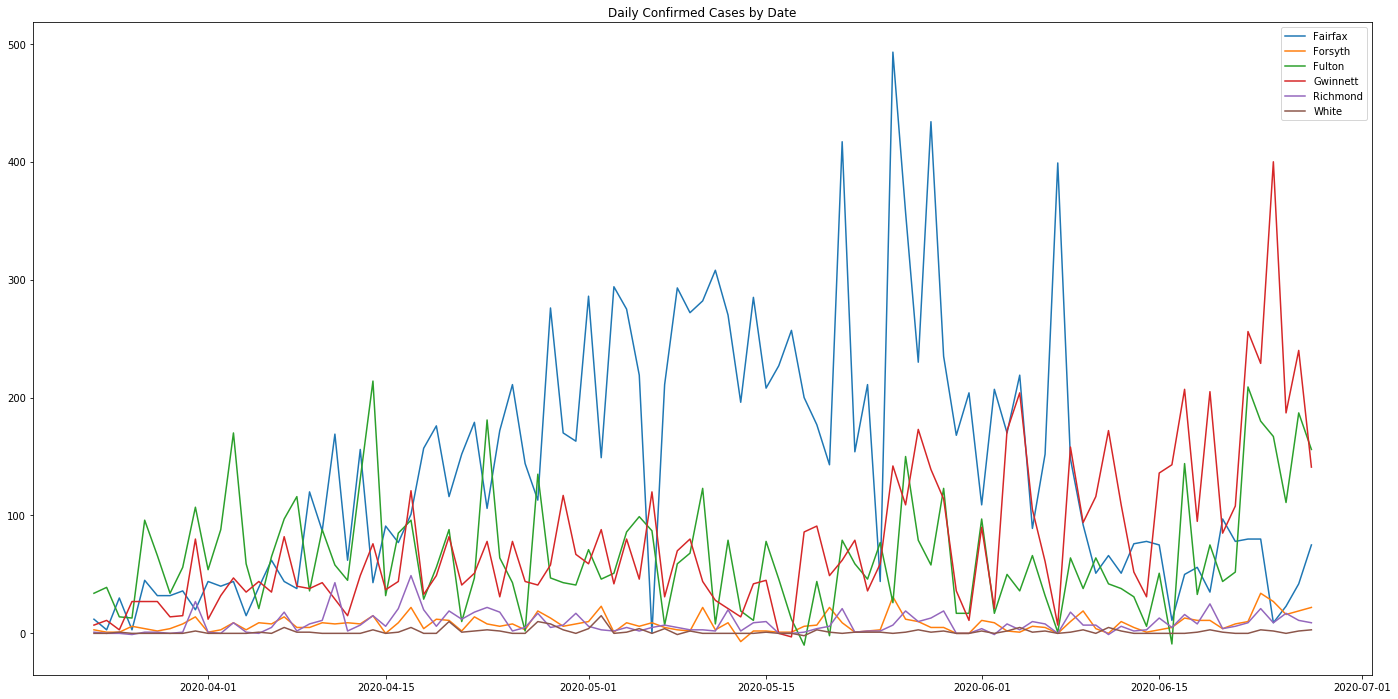

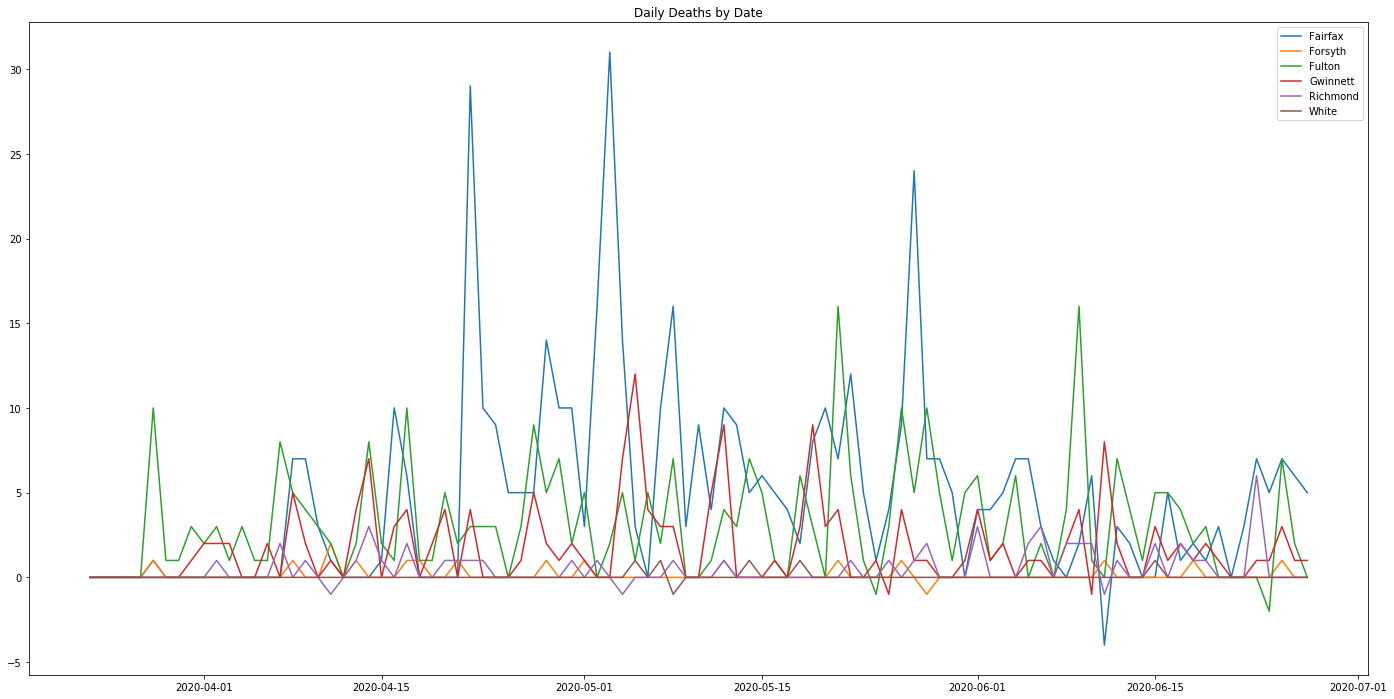

In [3]:
#STEP 5: Analyze the data for several specific regions

#Create the list of countries, provinces and regions triples
regions = [['US','Virginia','Fairfax'],['US','Georgia','Forsyth'],['US','Georgia','Fulton'],['US','Georgia','Gwinnett'],['US','Georgia','Richmond'],['US','Georgia','White']]

#Set the plot size
plt.figure(figsize=[24,12])

#Look through the list of regional triples to create the plots
for c, s, r in regions:  
    adf = df[(df.Country == c) & (df.Province == s) & (df.Region == r)]

    #Reset the index after the merge
    adf = adf.reset_index(drop=True)

    #Sort the values for convenience
    adf = adf.sort_values(by=['Date'])

    #Convert to datetime so it sorts by date, not by string
    adf.Date = pd.to_datetime(adf.Date)

    #Calculate the Daily Confirmed Cases

    adf['Daily_Confirmed'] = adf.Total_Confirmed - adf.Total_Confirmed.shift(1)
    adf['Daily_Deaths'] = adf.Total_Deaths - adf.Total_Deaths.shift(1)
    adf['Daily_Recovered'] = adf.Total_Recovered - adf.Total_Recovered.shift(1)
    adf['Daily_Active'] = adf.Total_Active - adf.Total_Active.shift(1)

    #Drop the first row because the daily values will be NaN after the daily calculation
    adf = adf.drop(adf.index[0])
    #start_date = adf.Date.min()
    #adf.loc[adf.Date == start_date, 'Daily_Confirmed'] = adf[adf.Date == start_date].Total_Confirmed

    plt.plot(adf.Date, adf.Daily_Confirmed, label=r)

plt.legend()
plt.title(label='Daily Confirmed Cases by Date', loc='center')
plt.show()
plt.close()

#STEP 5A: Plot the daily deaths
#Set the plot size
plt.figure(figsize=[24,12])

#Look through the list of regional triples to create the plots
for c, s, r in regions:  
    adf = df[(df.Country == c) & (df.Province == s) & (df.Region == r)]

    #Reset the index after the merge
    adf = adf.reset_index(drop=True)

    #Sort the values for convenience
    adf = adf.sort_values(by=['Date'])

    #Convert to datetime so it sorts by date, not by string
    adf.Date = pd.to_datetime(adf.Date)

    #Calculate the Daily Confirmed Cases

    adf['Daily_Confirmed'] = adf.Total_Confirmed - adf.Total_Confirmed.shift(1)
    adf['Daily_Deaths'] = adf.Total_Deaths - adf.Total_Deaths.shift(1)
    adf['Daily_Recovered'] = adf.Total_Recovered - adf.Total_Recovered.shift(1)
    adf['Daily_Active'] = adf.Total_Active - adf.Total_Active.shift(1)

    #Drop the first row because the daily values will be NaN after the daily calculation
    adf = adf.drop(adf.index[0])
    #start_date = adf.Date.min()
    #adf.loc[adf.Date == start_date, 'Daily_Confirmed'] = adf[adf.Date == start_date].Total_Confirmed

    plt.plot(adf.Date, adf.Daily_Deaths, label=r)

plt.legend()
plt.title(label='Daily Deaths by Date', loc='center')
plt.show()
plt.close()

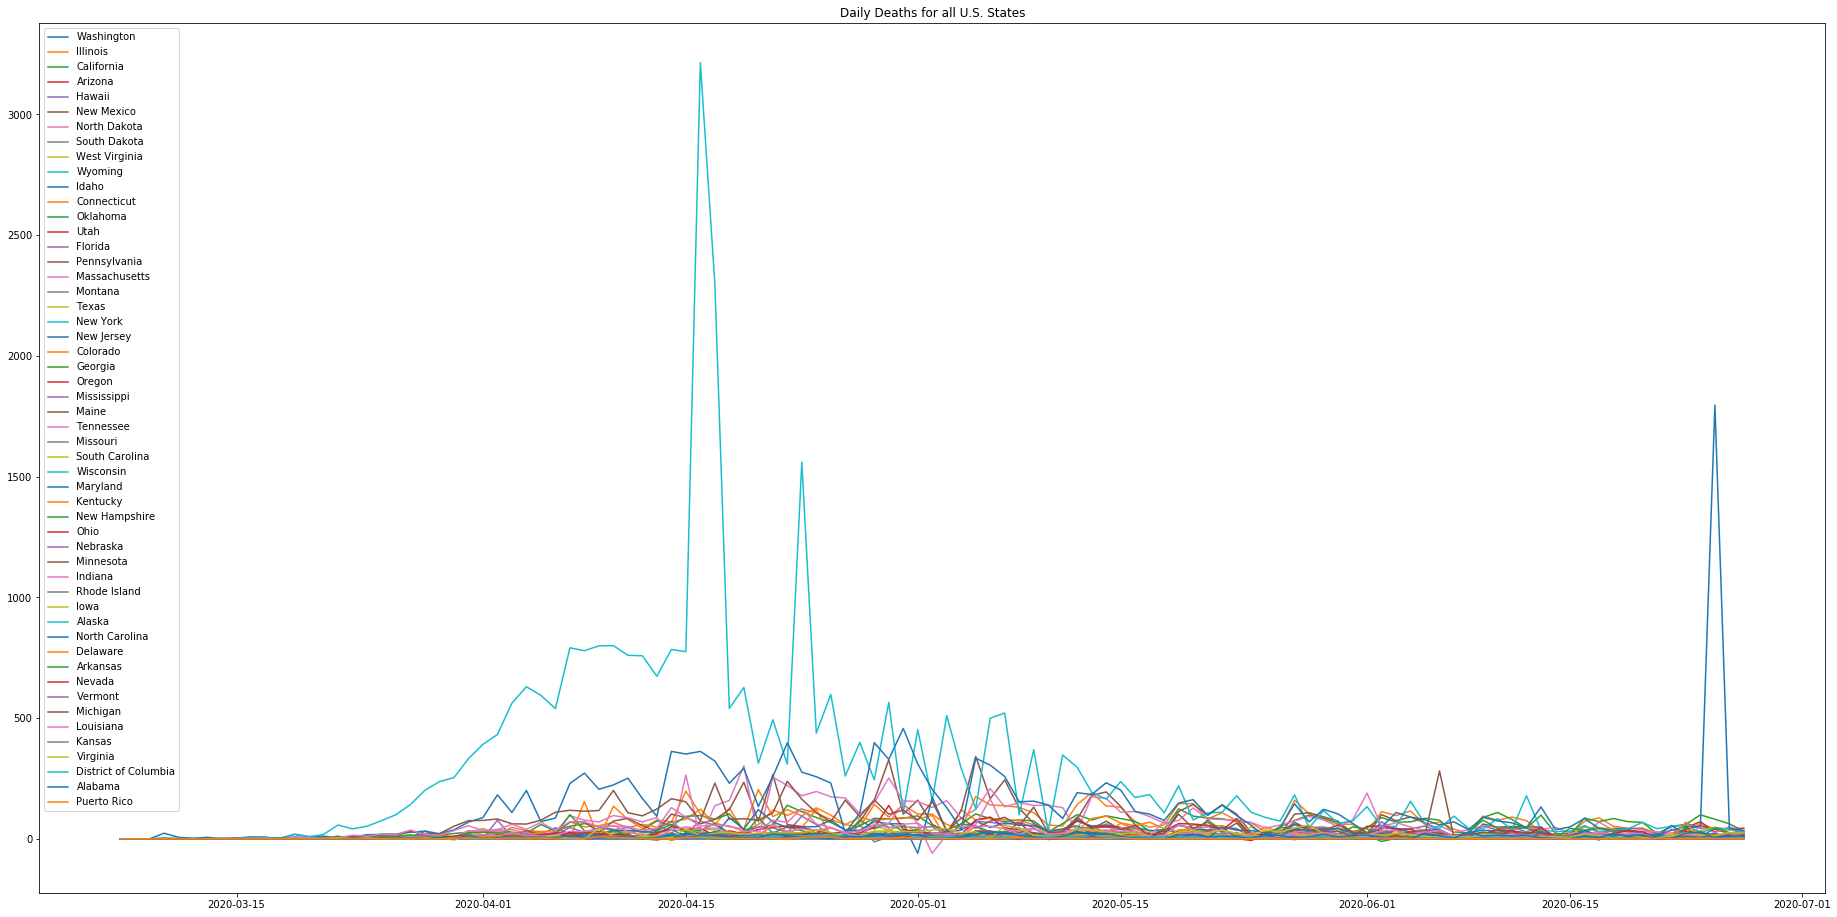

In [4]:
#STEP 8: plot the confirmed cases for all states in the US
df8 = df7.copy()

df8 = df8[df8.Date > '2020-03-05']

#Set the plot size
plt.figure(figsize=[32,16])

for index, p in provinces.iterrows():
    tempdf = df8[df8.Province == p.Province]

    #Reset the index after the merge
    tempdf = tempdf.reset_index(drop=True)

    #Sort the values for convenience
    tempdf = tempdf.sort_values(by=['Date'])

    #Convert to datetime so it sorts by date, not by string
    tempdf.Date = pd.to_datetime(tempdf.Date)

    #Calculate the Daily Confirmed Cases
    tempdf['Daily_Confirmed'] = tempdf.Total_Confirmed - tempdf.Total_Confirmed.shift(1)
    tempdf['Daily_Deaths'] = tempdf.Total_Deaths - tempdf.Total_Deaths.shift(1)
    tempdf['Daily_Recovered'] = tempdf.Total_Recovered - tempdf.Total_Recovered.shift(1)
    tempdf['Daily_Active'] = tempdf.Total_Active - tempdf.Total_Active.shift(1)

    #Drop the first row because the daily values will be NaN after the daily calculation
    tempdf = tempdf.drop(tempdf.index[0])
    #start_date = adf.Date.min()
    #adf.loc[adf.Date == start_date, 'Daily_Confirmed'] = adf[adf.Date == start_date].Total_Confirmed

    #if p.Province != 'New York' and p.Province != 'New Jersey':
    plt.plot(tempdf.Date, tempdf.Daily_Deaths, label=p.Province)

plt.legend(loc='upper left')
plt.title(label='Daily Deaths for all U.S. States', loc='center')
plt.show()
plt.close()

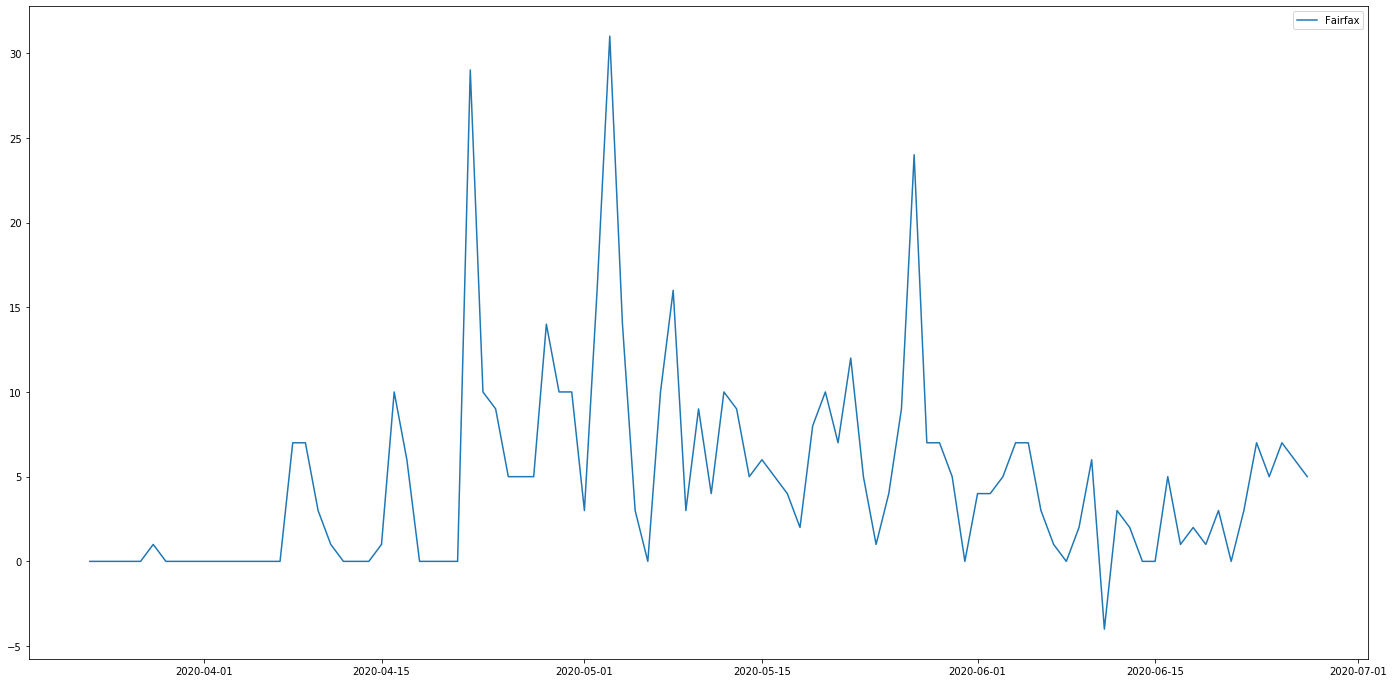

In [5]:
#Analyze the data for one specific region

adf = df[(df.Country == 'US') & (df.Province == 'Virginia') & (df.Region == 'Fairfax')]

#Reset the index after the merge
adf = adf.reset_index(drop=True)

#Sort the values for convenience
adf = adf.sort_values(by=['Date'])

#Convert to datetime so it sorts by date, not by string
adf.Date = pd.to_datetime(adf.Date)

#Calculate the Daily Confirmed Cases

adf['Daily_Confirmed'] = adf.Total_Confirmed - adf.Total_Confirmed.shift(1)
adf['Daily_Deaths'] = adf.Total_Deaths - adf.Total_Deaths.shift(1)
adf['Daily_Recovered'] = adf.Total_Recovered - adf.Total_Recovered.shift(1)
adf['Daily_Active'] = adf.Total_Active - adf.Total_Active.shift(1)

#Drop the first row because the daily values will be NaN after the daily calculation
adf = adf.drop(adf.index[0])
#start_date = adf.Date.min()
#adf.loc[adf.Date == start_date, 'Daily_Confirmed'] = adf[adf.Date == start_date].Total_Confirmed

plt.figure(figsize=[24,12])
plt.plot(adf.Date, adf.Daily_Deaths, label='Fairfax')

plt.legend()
plt.show()
plt.close()